# 1. Data Splitting (80:20 - Train: Test) stratified by sex
Saved train and test set separately

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

# --- Load winsorized dataset ---
df = pd.read_csv("ML_child_obesity_syn_data.csv")

# --- Force columns to integer, allowing NA ---
int_columns = ["income", "parent_ed", "sex", "risk_status_mom"]
for col in int_columns:
    df[col] = pd.to_numeric(df[col], errors="coerce").round().astype("Int64")  # nullable integer

# --- Drop rows with NA in stratify column ---
df = df[df["sex"].notna()].copy()
df["sex"] = df["sex"].astype(int)  # safe now that no NA

# --- Stratified split based on 'sex' ---
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["sex"],
    random_state=42
)

# --- Save splits if needed ---
train_df.to_csv("train_split_stratified.csv", index=False)
test_df.to_csv("test_split_stratified.csv", index=False)

# --- Optional: Check class balance ---
print("Sex distribution in full data:\n", df["sex"].value_counts(normalize=True))
print("Sex distribution in train:\n", train_df["sex"].value_counts(normalize=True))
print("Sex distribution in test:\n", test_df["sex"].value_counts(normalize=True))

# 2. Missing Data Analysis - separate train and test

Visualizing missing data - train and test separate


Train Set Missingness Summary:
                       Missing Count  Missing %    Dtype
avg_sleep_frag_index            137  49.818182  float64
brief2_gec_p                     46  16.727273  float64
mean_mvpa                        33  12.000000  float64
mean_sedentary                   33  12.000000  float64
tfeq_hunger                      17   6.181818  float64
tfeq_cogcontrol                  13   4.727273  float64
cebq_approach                    10   3.636364  float64
cebq_eoe                         10   3.636364  float64
cebq_avoid                        9   3.272727  float64
tfeq_disinhibition                8   2.909091  float64
income                            7   2.545455  float64
cfq_pcw                           6   2.181818  float64
cfq_cwc                           6   2.181818  float64
bis                               6   2.181818  float64
cebq_ff                           5   1.818182  float64
v1_eah_total_kcal                 5   1.818182  float64
cebq_se        

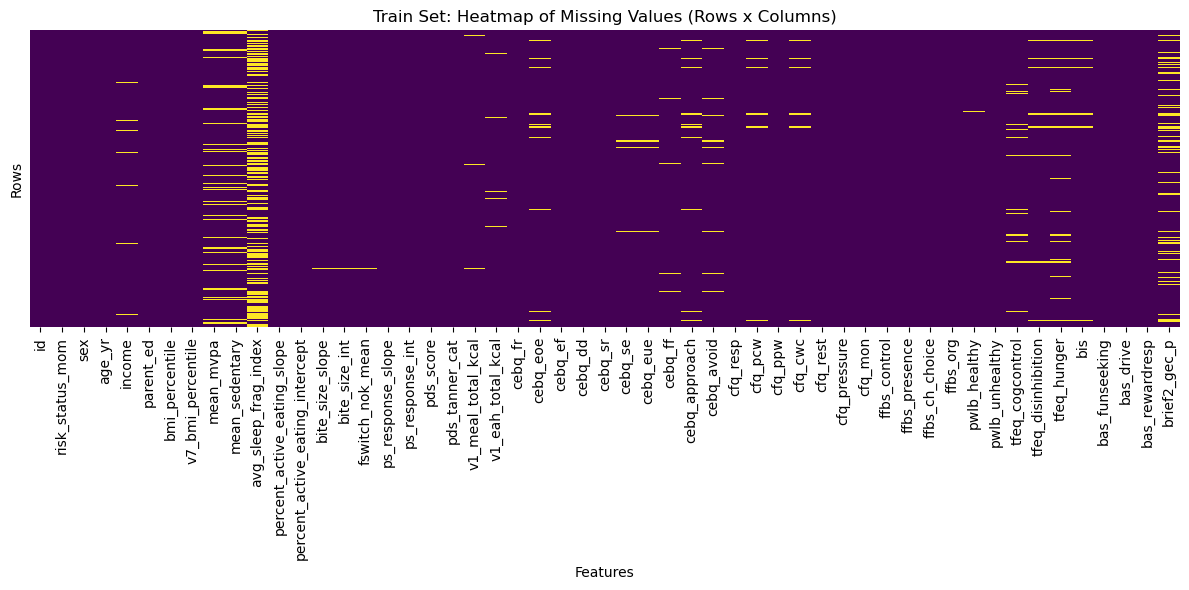

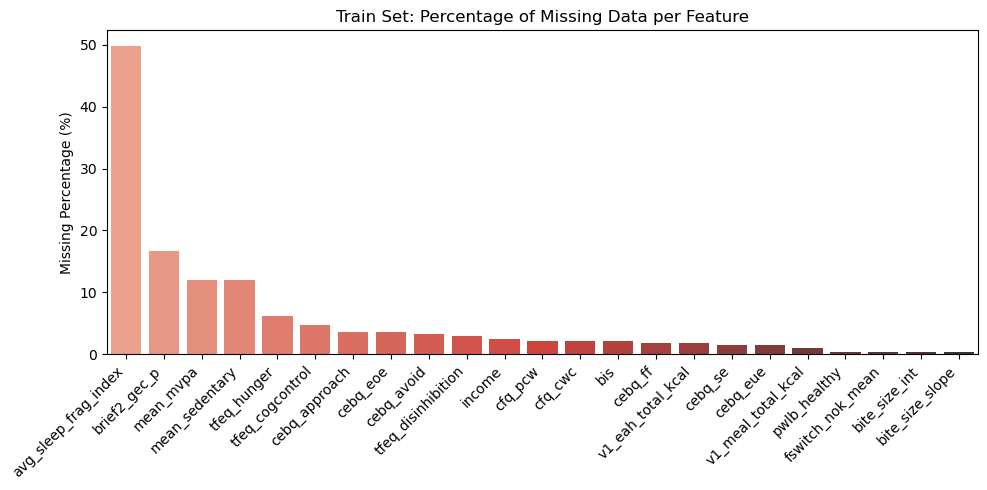


Test Set Missingness Summary:
                       Missing Count  Missing %    Dtype
avg_sleep_frag_index             32  46.376812  float64
mean_mvpa                         8  11.594203  float64
mean_sedentary                    8  11.594203  float64
brief2_gec_p                      8  11.594203  float64
tfeq_cogcontrol                   4   5.797101  float64
tfeq_hunger                       4   5.797101  float64
cebq_eoe                          2   2.898551  float64
cebq_approach                     2   2.898551  float64
income                            1   1.449275  float64
cfq_pcw                           1   1.449275  float64
cfq_cwc                           1   1.449275  float64
tfeq_disinhibition                1   1.449275  float64
bis                               1   1.449275  float64


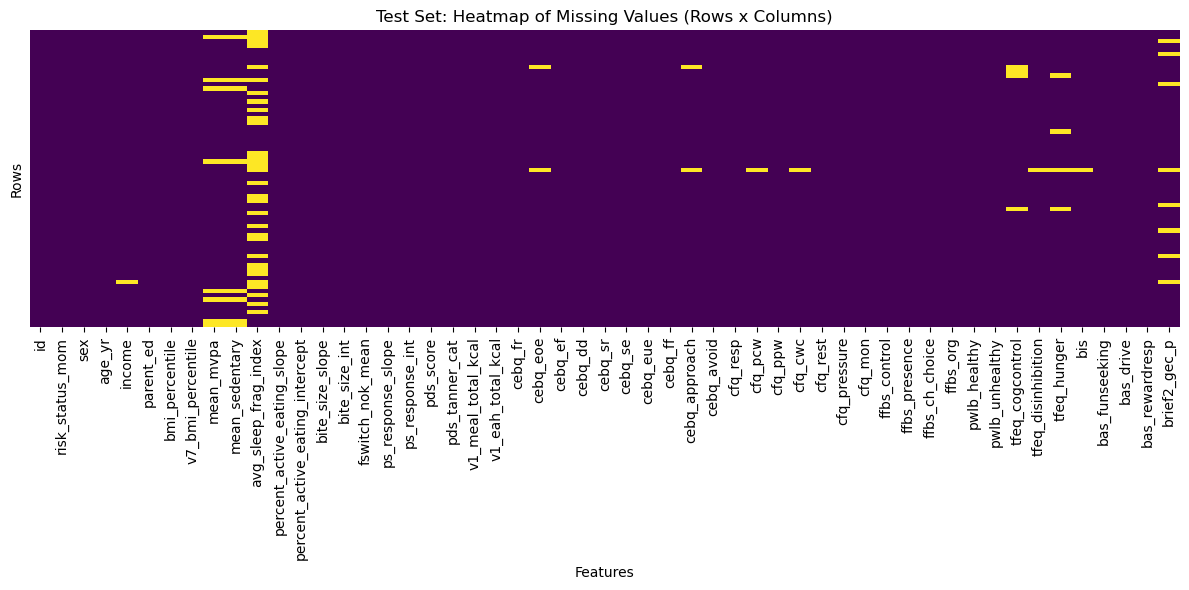

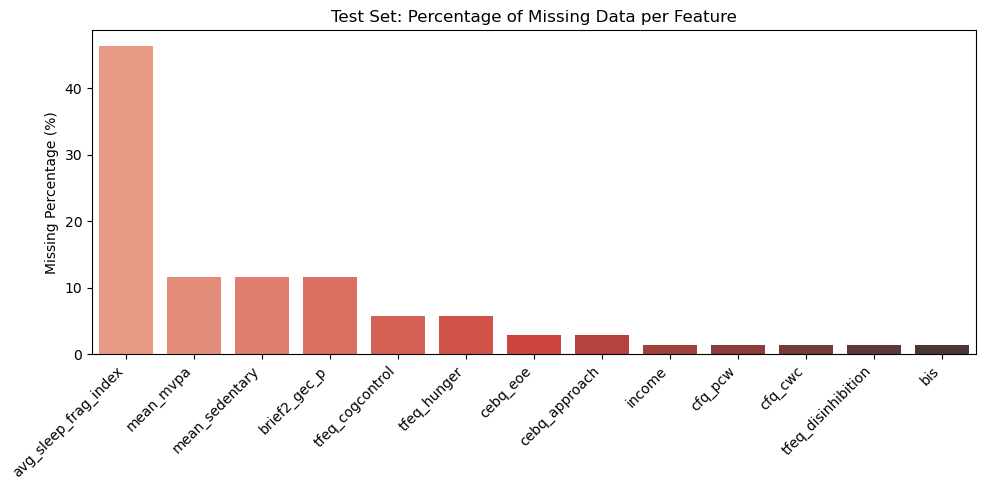

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_missingness(df, name):
    # --- Tabular Missingness Summary ---
    missing_summary = pd.DataFrame({
        "Missing Count": df.isnull().sum(),
        "Missing %": (df.isnull().sum() / len(df)) * 100,
        "Dtype": df.dtypes
    })
    missing_summary = missing_summary[missing_summary["Missing Count"] > 0]
    missing_summary = missing_summary.sort_values(by="Missing %", ascending=False)
    print(f"\n{name} Missingness Summary:\n", missing_summary)

    # --- Visualization 1: Heatmap of Missing Rows x Columns ---
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap="viridis")
    plt.title(f"{name}: Heatmap of Missing Values (Rows x Columns)")
    plt.xlabel("Features")
    plt.ylabel("Rows")
    plt.tight_layout()
    plt.show()

    # --- Visualization 2: Missing % per Column ---
    missing_percent = (df.isnull().sum() / len(df)) * 100
    missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=missing_percent.index, y=missing_percent.values, palette="Reds_d")
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Missing Percentage (%)")
    plt.title(f"{name}: Percentage of Missing Data per Feature")
    plt.tight_layout()
    plt.show()

# ----------------------------
# Load train and test datasets
# ----------------------------
train_df = pd.read_csv("train_split_stratified.csv")
test_df = pd.read_csv("test_split_stratified.csv")

# ----------------------------
# Analyze Missingness
# ----------------------------
analyze_missingness(train_df, "Train Set")
analyze_missingness(test_df, "Test Set")


train data: Since there is nearly 50% missing in avg sleep fragmentation data, we are not considering that for modeling. 20-10% can be imputed but needs to be considered carefully; kNN imputation can help especially for behavior data that is variable. 10-0% - very okay with light imputation(kNN or mean/median/mode impute). 

#### Addressing missing data with kNN imputation, mode imputation

In [24]:
import pandas as pd
from sklearn.impute import KNNImputer

def impute_dataset(input_path, output_path):
    df = pd.read_csv(input_path)

    # --- Step 1: Drop high-missingness column ---
    if 'avg_sleep_frag_index' in df.columns:
        df.drop(columns=['avg_sleep_frag_index'], inplace=True)

    # --- Step 2: KNN Impute moderate-missingness continuous features (5–15%) ---
    knn_cols = [
        'brief2_gec_p',
        'mean_mvpa',
        'mean_sedentary',
        'tfeq_hunger',
        'tfeq_cogcontrol'
    ]

    knn_cols_existing = [col for col in knn_cols if col in df.columns]
    if knn_cols_existing:
        knn_imputer = KNNImputer(n_neighbors=5)
        df[knn_cols_existing] = knn_imputer.fit_transform(df[knn_cols_existing])

    # --- Step 3: Median Impute low-missingness continuous features (<5%) ---
    low_missing_continuous = [
        'v1_meal_total_kcal', 'cebq_eoe', 'cebq_approach', 'cebq_avoid',
        'tfeq_disinhibition', 'v1_eah_total_kcal', 'fswitch_nok_mean',
        'pwlb_healthy', 'bite_size_int', 'bite_size_slope',
        'bis', 'cfq_cwc', 'cfq_pcw', 'cebq_ff', 'cebq_se', 'cebq_eue'
    ]

    for col in low_missing_continuous:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].median())

    # --- Step 4: Mode Impute ordinal categorical variable ---
    if 'income' in df.columns and df['income'].isnull().any():
        df['income'] = df['income'].fillna(df['income'].mode()[0])

    # --- Save cleaned dataset ---
    df.to_csv(output_path, index=False)

# --- Apply to both train and test splits ---
impute_dataset("train_split_stratified.csv", "train_split_imputed.csv")
impute_dataset("test_split_stratified.csv", "test_split_imputed.csv")

print("✅ Imputed train and test datasets saved.")

✅ Imputed train and test datasets saved.


# 3. Visualizing Outliers

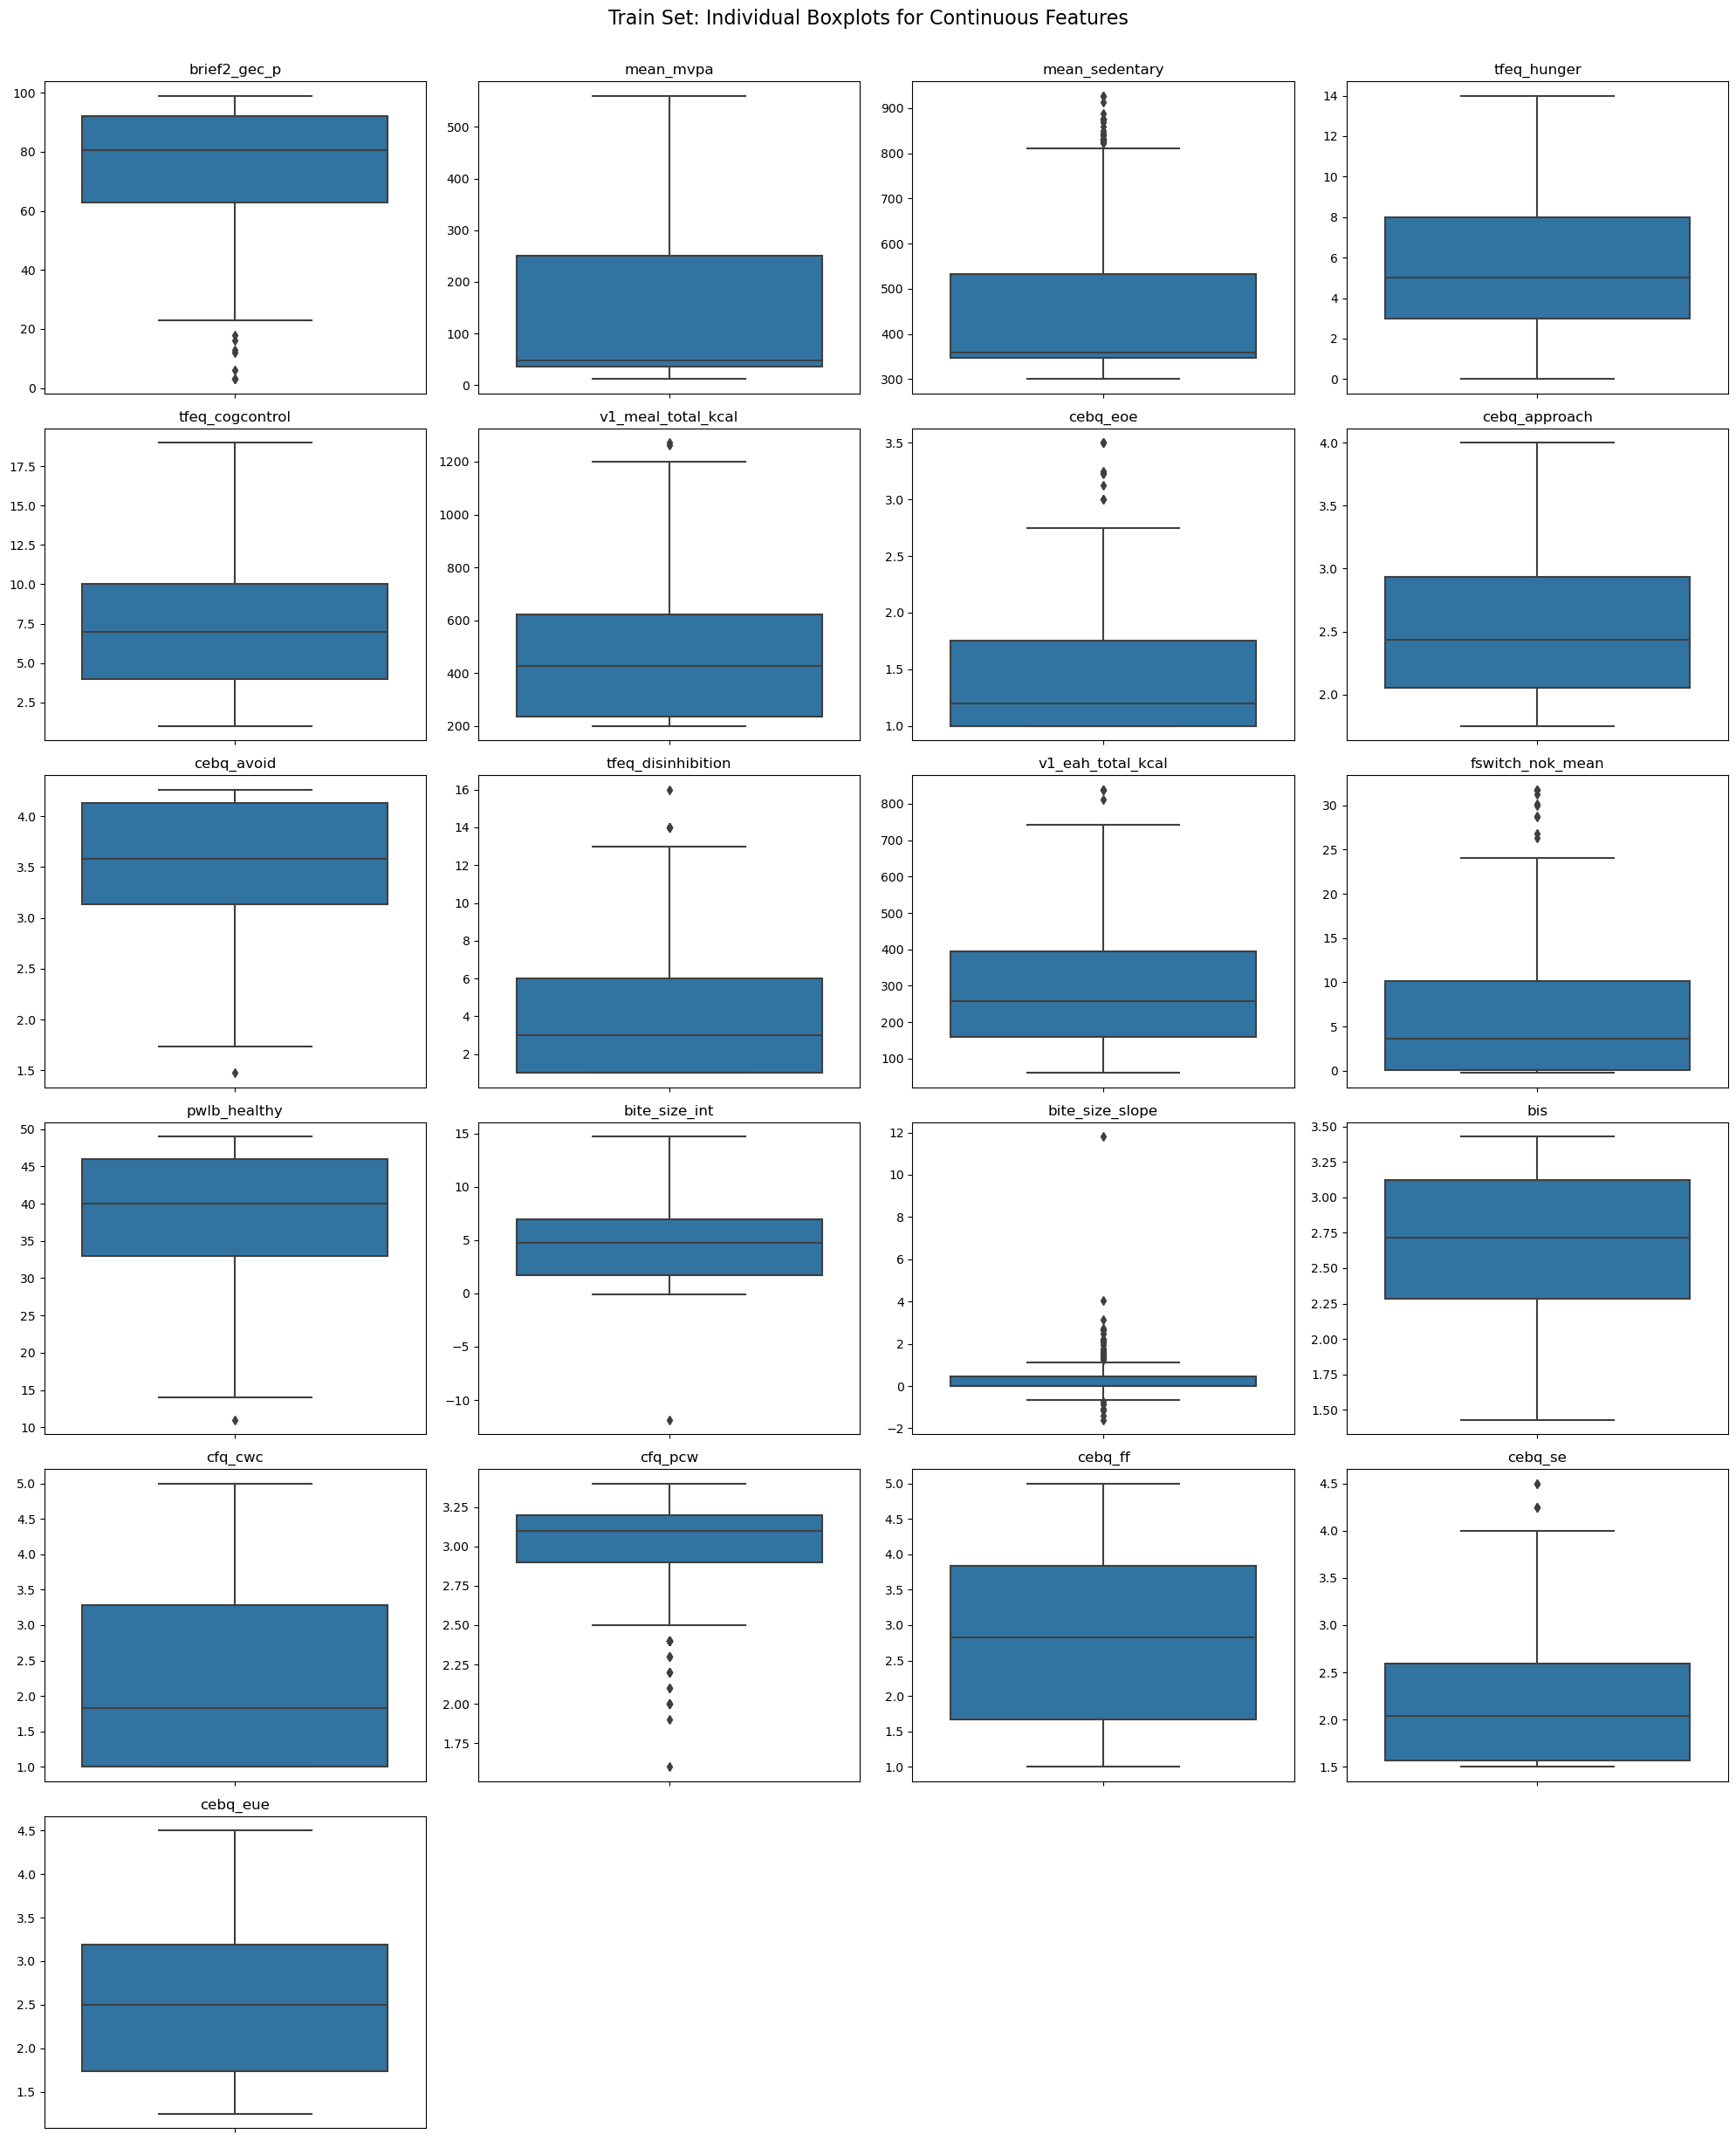

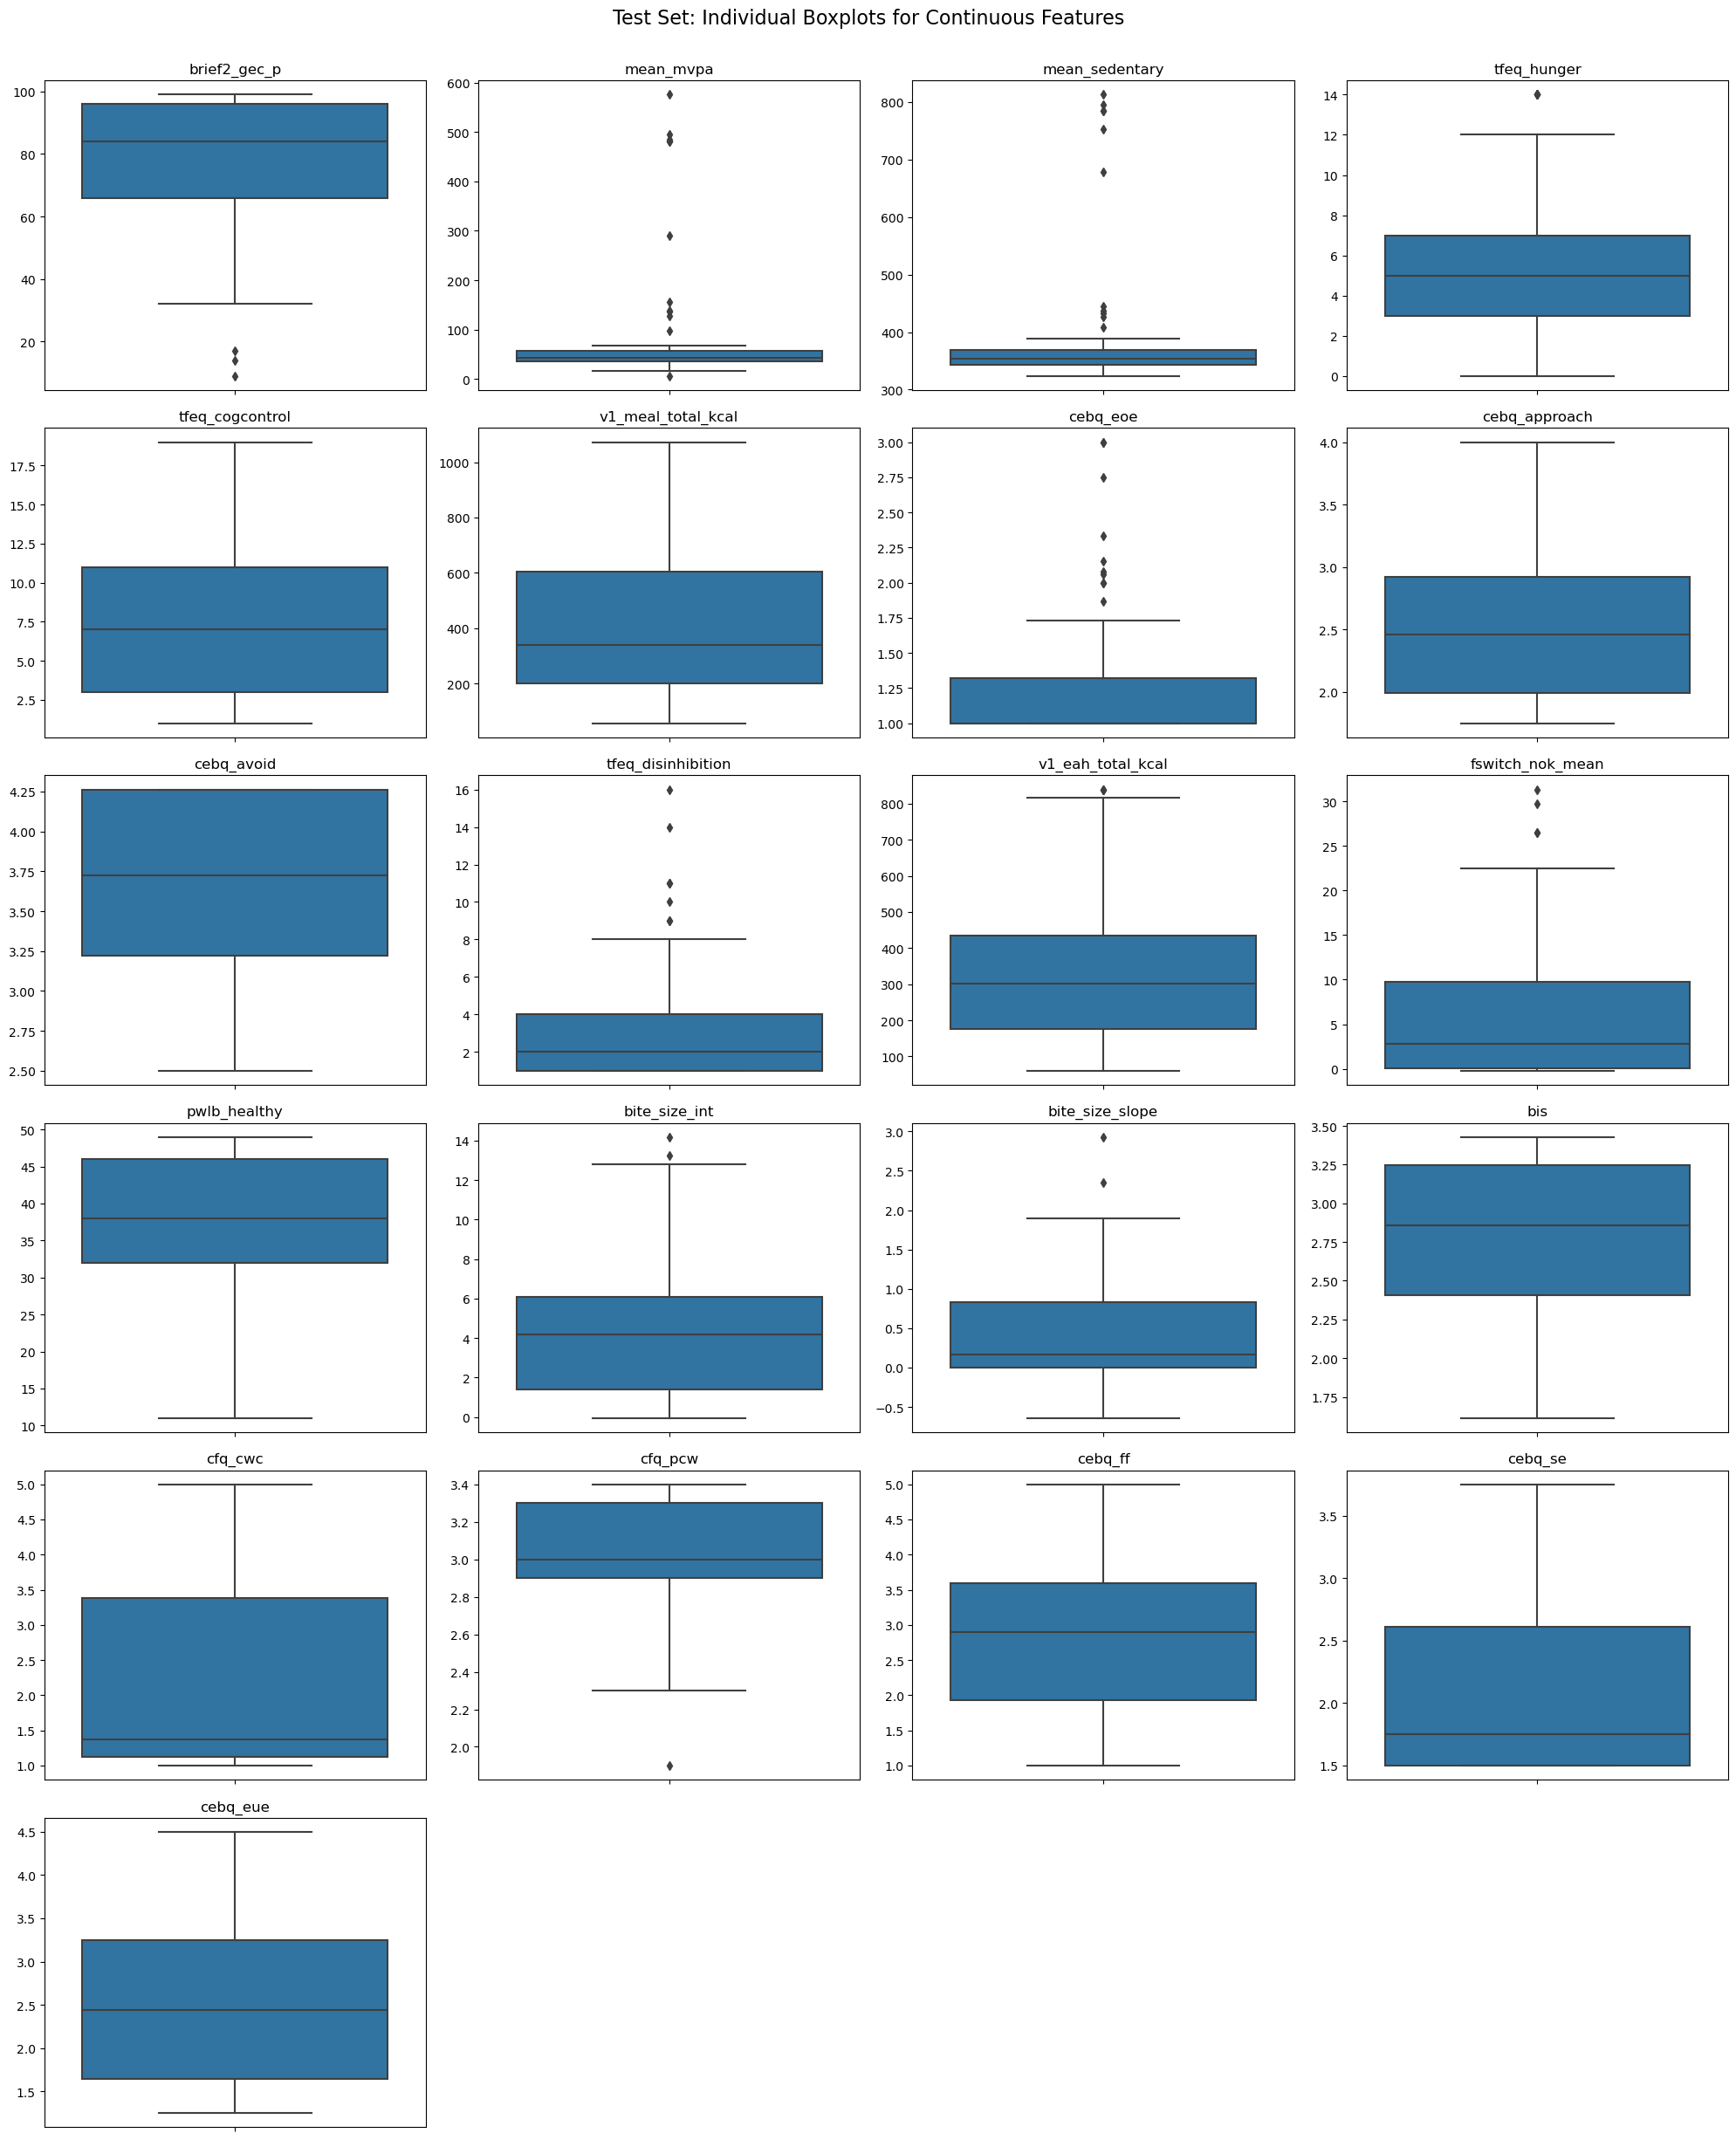

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

# --- List of continuous variables ---
continuous_cols = [
    'brief2_gec_p', 'mean_mvpa', 'mean_sedentary',
    'tfeq_hunger', 'tfeq_cogcontrol', 'v1_meal_total_kcal',
    'cebq_eoe', 'cebq_approach', 'cebq_avoid', 'tfeq_disinhibition',
    'v1_eah_total_kcal', 'fswitch_nok_mean', 'pwlb_healthy',
    'bite_size_int', 'bite_size_slope', 'bis',
    'cfq_cwc', 'cfq_pcw', 'cebq_ff', 'cebq_se', 'cebq_eue'
]

def plot_continuous_boxplots(df, title_prefix):
    n_cols = 4
    n_rows = math.ceil(len(continuous_cols) / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))

    for idx, col in enumerate(continuous_cols):
        row = idx // n_cols
        col_idx = idx % n_cols
        ax = axes[row, col_idx] if n_rows > 1 else axes[col_idx]

        if col in df.columns:
            sns.boxplot(data=df, y=col, ax=ax)
            ax.set_title(col)
            ax.set_xlabel("")
            ax.set_ylabel("")
        else:
            ax.set_visible(False)

    # Hide unused subplots
    for idx in range(len(continuous_cols), n_rows * n_cols):
        fig.delaxes(axes.flatten()[idx])

    plt.tight_layout()
    plt.suptitle(f"{title_prefix}: Individual Boxplots for Continuous Features", y=1.02, fontsize=16)
    plt.show()

# --- Load and plot for Train set ---
train_df = pd.read_csv("train_split_imputed.csv")
plot_continuous_boxplots(train_df, "Train Set")

# --- Load and plot for Test set ---
test_df = pd.read_csv("test_split_imputed.csv")
plot_continuous_boxplots(test_df, "Test Set")

## Winsorizing outliers

In [26]:
import pandas as pd

# --- Winsorization helpers ---
def compute_winsor_limits(series, lower=0.01, upper=0.99):
    return series.quantile(lower), series.quantile(upper)

def apply_winsorization(series, lower_limit, upper_limit):
    return series.clip(lower=lower_limit, upper=upper_limit)

# --- Columns to winsorize ---
continuous_cols = [
    'mean_sedentary', 'cebq_eoe', 'cebq_approach', 'v1_meal_total_kcal',
    'v1_eah_total_kcal', 'bite_size_int', 'bite_size_slope',
    'cfq_cwc', 'cfq_pcw'
]

# --- Load train set ---
train_df = pd.read_csv("train_split_imputed.csv")

# --- Compute and apply winsorization to train set ---
winsor_limits = {}
for col in continuous_cols:
    if col in train_df.columns:
        lower, upper = compute_winsor_limits(train_df[col], 0.01, 0.99)
        winsor_limits[col] = (lower, upper)
        train_df[col] = apply_winsorization(train_df[col], lower, upper)
    else:
        print(f"⚠️ Column '{col}' not found in train set")

# --- Save train set ---
train_df.to_csv("train_split_winsorized.csv", index=False)

# --- Load test set ---
test_df = pd.read_csv("test_split_imputed.csv")

# --- Apply train-derived winsorization to test set ---
for col in continuous_cols:
    if col in test_df.columns and col in winsor_limits:
        lower, upper = winsor_limits[col]
        test_df[col] = apply_winsorization(test_df[col], lower, upper)
    else:
        print(f"⚠️ Column '{col}' not found in test set or missing winsor limits")

# --- Save test set ---
test_df.to_csv("test_split_winsorized.csv", index=False)

print("✅ Winsorized datasets saved as 'train_split_winsorized.csv' and 'test_split_winsorized.csv'")

✅ Winsorized datasets saved as 'train_split_winsorized.csv' and 'test_split_winsorized.csv'


## 4. Feature Transformation
One-hot-encoding for nominal categorical data
Ordinal data can be left as is

In [28]:
import pandas as pd

def one_hot_encode_sex(input_path, output_path):
    df = pd.read_csv(input_path)

    if 'sex' in df.columns:
        df = pd.get_dummies(df, columns=['sex'], drop_first=True)
    
    df.to_csv(output_path, index=False)

# Apply to both train and test winsorized splits, save as final
one_hot_encode_sex("train_split_winsorized.csv", "train_split_final.csv")
one_hot_encode_sex("test_split_winsorized.csv", "test_split_final.csv")

print("✅ One-hot encoding of 'sex' completed and saved as 'train_split_final.csv' and 'test_split_final.csv'.")

✅ One-hot encoding of 'sex' completed and saved as 'train_split_final.csv' and 'test_split_final.csv'.


# 5. Feature Selection

#### A. Feature Analysis: Which features or predictors have low variability?

In [29]:
## Data Variability
import pandas as pd

# Load train split
df_train = pd.read_csv("train_split_final.csv")

# Drop ID if present
df_train = df_train.drop(columns=['id'], errors='ignore')

# Threshold: below this std or unique % is considered low variability
low_std_thresh = 0.01
low_unique_thresh = 0.01  # 1% of sample size

n_rows = df_train.shape[0]
low_variability = []

for col in df_train.select_dtypes(include=['float64', 'int64']).columns:
    std = df_train[col].std()
    unique_vals = df_train[col].nunique()
    unique_pct = unique_vals / n_rows
    if std < low_std_thresh or unique_pct < low_unique_thresh:
        low_variability.append((col, round(std, 4), unique_vals, round(unique_pct, 4)))

# Show results
low_var_df = pd.DataFrame(low_variability, columns=['Feature', 'Std Dev', 'Unique Values', 'Unique %'])
print("⚠️ Low Variability Features:")
print(low_var_df)

⚠️ Low Variability Features:
           Feature  Std Dev  Unique Values  Unique %
0  risk_status_mom   0.4829              2    0.0073


#### Visualizing correlation to outcome (v7_bmi_percentile: Follow-up BMI percentile)

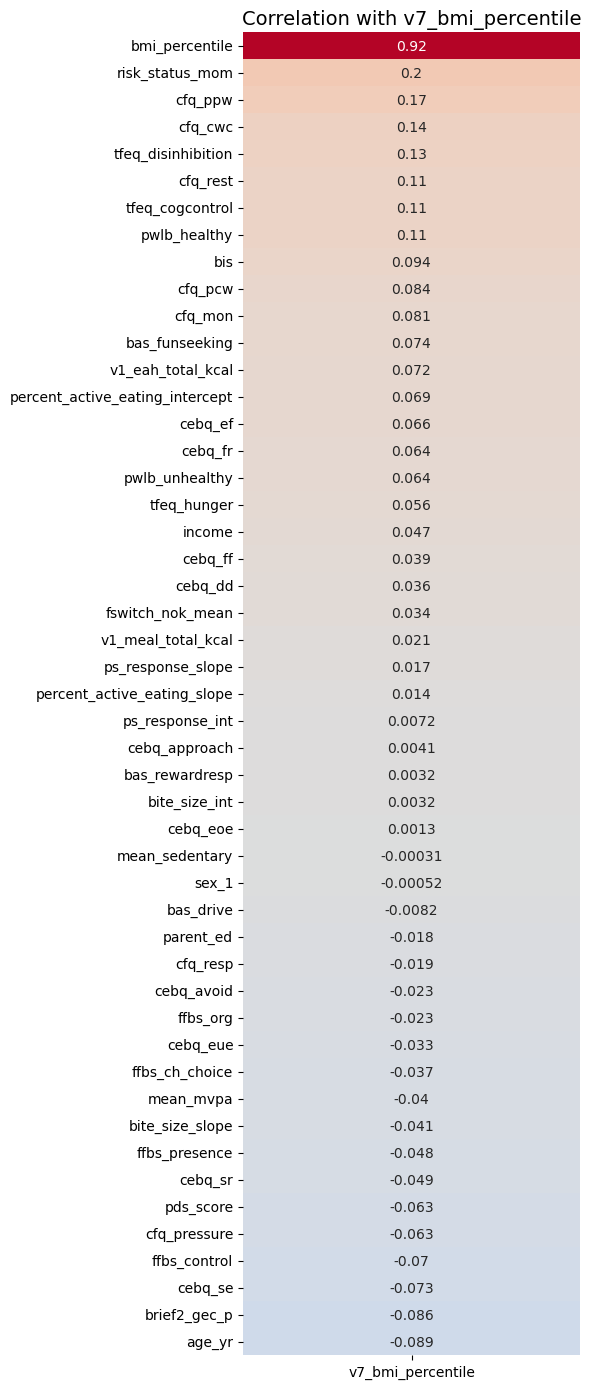

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Load dataset ---
df = pd.read_csv("train_split_final.csv")

# --- List of selected features for modeling ---
selected_features = [
    'risk_status_mom', 'age_yr', 'income', 'parent_ed', 
    'bmi_percentile','mean_mvpa','mean_sedentary', 
    'percent_active_eating_slope' , 'percent_active_eating_intercept', 
    'bite_size_slope', 'bite_size_int',	'fswitch_nok_mean',	
    'ps_response_slope','ps_response_int',	
    'pds_score', 'v1_meal_total_kcal', 'v1_eah_total_kcal', 'cebq_fr', 'cebq_eoe', 
    'cebq_ef', 'cebq_dd', 'cebq_sr', 'cebq_se',	'cebq_eue', 'cebq_ff', 'cebq_approach',	'cebq_avoid','cfq_resp',
    'cfq_pcw','cfq_ppw', 'cfq_cwc',	'cfq_rest', 'cfq_pressure', 'cfq_mon', 'ffbs_control',
    'ffbs_presence','ffbs_ch_choice','ffbs_org','pwlb_healthy',	'pwlb_unhealthy','tfeq_cogcontrol', 
    'tfeq_disinhibition', 'tfeq_hunger', 'bis',	'bas_funseeking', 'bas_drive', 'bas_rewardresp',	'brief2_gec_p',	'sex_1'
]

# --- Compute correlations with v7_bmi_percentile ---
target = 'v7_bmi_percentile'
correlations = df[selected_features + [target]].corr()[target].drop(target).sort_values(ascending=False)

# --- Plot as vertical heatmap ---
plt.figure(figsize=(6, 14))
sns.heatmap(correlations.to_frame(), annot=True, cmap="coolwarm", center=0, cbar=False)
plt.title("Correlation with v7_bmi_percentile", fontsize=14)
plt.tight_layout()
plt.show()

Baseline BMI percentile explains a lot of follow-up BMI percentile. Since the idea is predicting future obesity accurately, adding baseline BMI percentile will help. However, this masks the influence of other behavioral factors. Therefore, we can do RFE next without baseline BMI percentile to help understand the important features without getting masked by basline BMI%. We will train 2 models - one with baseline BMI%, one without. One with baseline BMI% can help with model accuracy; one without helps understand the patterns of behavior beyond baseline BMI%. 

#### Nested Cross-Validation (outer loop: cross validation for hyperparameters; inner loop: RFE-CV) - with BMI%


🔁 Outer Fold 1
✅ Best MAE: 4.39
📊 Best Hyperparams: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
🔢 Features Selected (1): ['bmi_percentile']

🔁 Outer Fold 2
✅ Best MAE: 3.85
📊 Best Hyperparams: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
🔢 Features Selected (3): ['bmi_percentile', 'mean_mvpa', 'mean_sedentary']

🔁 Outer Fold 3
✅ Best MAE: 3.74
📊 Best Hyperparams: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
🔢 Features Selected (1): ['bmi_percentile']


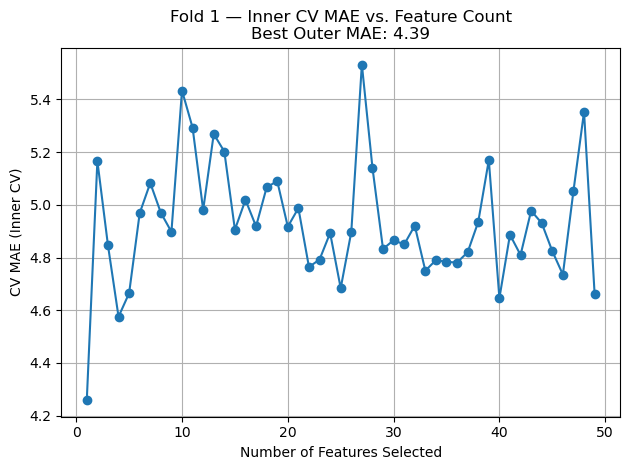

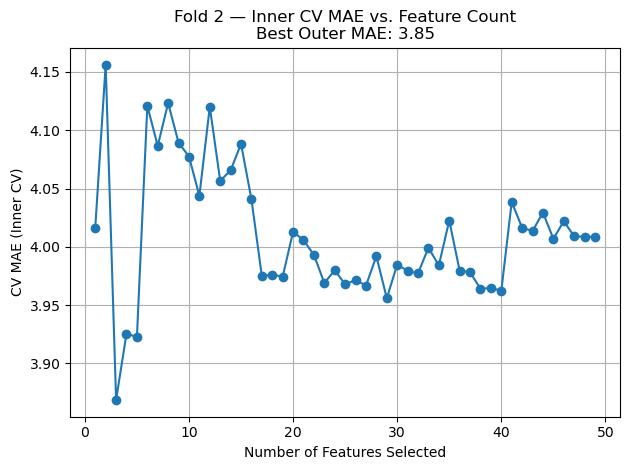

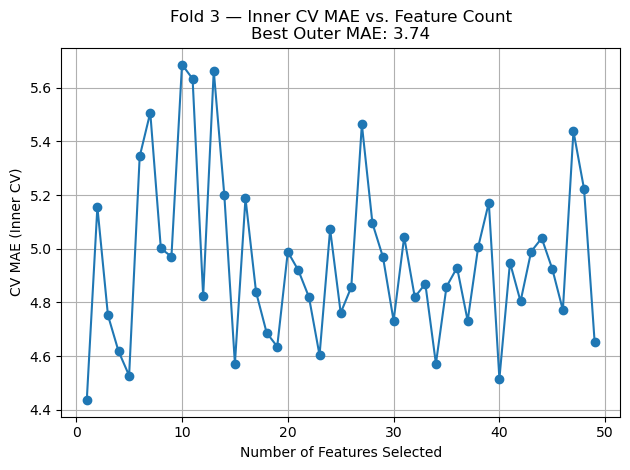


🏆 === BEST COMBINATION ACROSS ALL FOLDS ===
Best found in outer fold: 3
Lowest MAE: 3.74

🔧 Best Hyperparameter Configuration:
  colsample_bytree: 0.8
  learning_rate: 0.1
  max_depth: 3
  n_estimators: 50
  subsample: 0.8

📌 Features Selected (Total: 1):
  - bmi_percentile


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# Load dataset
df = pd.read_csv("train_split_final.csv")

# Define features and target
feature_cols = [
    'risk_status_mom', 'age_yr', 'income', 'parent_ed',
    'bmi_percentile', 'mean_mvpa', 'mean_sedentary',
    'percent_active_eating_slope', 'percent_active_eating_intercept',
    'bite_size_slope', 'bite_size_int', 'fswitch_nok_mean',
    'ps_response_slope', 'ps_response_int',
    'pds_score', 'v1_meal_total_kcal', 'v1_eah_total_kcal',
    'cebq_fr', 'cebq_eoe', 'cebq_ef', 'cebq_dd', 'cebq_sr', 'cebq_se',
    'cebq_eue', 'cebq_ff', 'cebq_approach', 'cebq_avoid', 'cfq_resp',
    'cfq_pcw', 'cfq_ppw', 'cfq_cwc', 'cfq_rest', 'cfq_pressure', 'cfq_mon',
    'ffbs_control', 'ffbs_presence', 'ffbs_ch_choice', 'ffbs_org',
    'pwlb_healthy', 'pwlb_unhealthy', 'tfeq_cogcontrol',
    'tfeq_disinhibition', 'tfeq_hunger', 'bis', 'bas_funseeking',
    'bas_drive', 'bas_rewardresp', 'brief2_gec_p', 'sex_1'
]
target = 'v7_bmi_percentile'
feature_names = np.array(feature_cols)

X = df[feature_cols].values
y = df[target].values

# 3-fold outer CV for honest model performance estimation
outer_cv = KFold(n_splits=3, shuffle=True, random_state=42)

# Hyperparameter grid for XGBoost
param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [50,100, 200],
    'subsample': [0.8],
    'colsample_bytree': [0.8, 1.0]
}

results_by_fold = []

# Outer loop
for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
    print(f"\n🔁 Outer Fold {fold}")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    fold_results = []

    # Grid search over hyperparameters
    for params in ParameterGrid(param_grid):
        model = XGBRegressor(objective='reg:squarederror', random_state=42, **params)

        # RFECV with 3-fold inner CV
        rfecv = RFECV(
            estimator=model,
            step=1,
            cv=3,
            scoring='neg_mean_absolute_error',
            n_jobs=-1
        )
        rfecv.fit(X_train, y_train)

        selected_mask = rfecv.support_
        selected_features = feature_names[selected_mask]

        # Re-train model on selected features
        model.fit(rfecv.transform(X_train), y_train)
        preds = model.predict(rfecv.transform(X_test))
        mae = mean_absolute_error(y_test, preds)

        fold_results.append({
            "params": params,
            "mae": mae,
            "n_features": selected_mask.sum(),
            "features": selected_features,
            "cv_mae_by_features": -rfecv.cv_results_['mean_test_score']
          # Flip to positive MAE
        })

    # Pick best inner model for this outer fold
    best = sorted(fold_results, key=lambda x: x['mae'])[0]
    results_by_fold.append(best)

    print(f"✅ Best MAE: {best['mae']:.2f}")
    print(f"📊 Best Hyperparams: {best['params']}")
    print(f"🔢 Features Selected ({best['n_features']}): {list(best['features'])}")

# Plot CV MAE vs. number of features
for i, res in enumerate(results_by_fold):
    plt.figure()
    plt.plot(range(1, len(res["cv_mae_by_features"]) + 1), res["cv_mae_by_features"], marker='o')
    plt.xlabel("Number of Features Selected")
    plt.ylabel("CV MAE (Inner CV)")
    plt.title(f"Fold {i+1} — Inner CV MAE vs. Feature Count\nBest Outer MAE: {res['mae']:.2f}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Best model across all folds
all_maes = [r['mae'] for r in results_by_fold]
best_fold_idx = int(np.argmin(all_maes))
best_overall = results_by_fold[best_fold_idx]

print("\n🏆 === BEST COMBINATION ACROSS ALL FOLDS ===")
print(f"Best found in outer fold: {best_fold_idx + 1}")
print(f"Lowest MAE: {best_overall['mae']:.2f}")

print("\n🔧 Best Hyperparameter Configuration:")
for key, val in best_overall['params'].items():
    print(f"  {key}: {val}")

print("\n📌 Features Selected (Total: {}):".format(best_overall['n_features']))
for feat in best_overall['features']:
    print(f"  - {feat}")

# Feature selection without baseline BMI%


🔁 Outer Fold 1
✅ Best MAE: 11.64
📊 Best Hyperparams: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}
🔢 Features Selected (17): ['mean_mvpa', 'mean_sedentary', 'bite_size_slope', 'ps_response_slope', 'pds_score', 'v1_meal_total_kcal', 'cfq_pcw', 'cfq_cwc', 'cfq_rest', 'ffbs_ch_choice', 'pwlb_healthy', 'tfeq_disinhibition', 'tfeq_hunger', 'bis', 'bas_drive', 'bas_rewardresp', 'brief2_gec_p']

🔁 Outer Fold 2
✅ Best MAE: 8.16
📊 Best Hyperparams: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
🔢 Features Selected (24): ['risk_status_mom', 'mean_mvpa', 'mean_sedentary', 'percent_active_eating_slope', 'fswitch_nok_mean', 'ps_response_slope', 'pds_score', 'v1_eah_total_kcal', 'cebq_fr', 'cebq_eoe', 'cebq_eue', 'cebq_avoid', 'cfq_resp', 'cfq_pcw', 'cfq_ppw', 'cfq_cwc', 'cfq_rest', 'cfq_pressure', 'cfq_mon', 'pwlb_healthy', 'tfeq_cogcontrol', 'tfeq_disinhibition', 'bas_drive', 'brief2_g

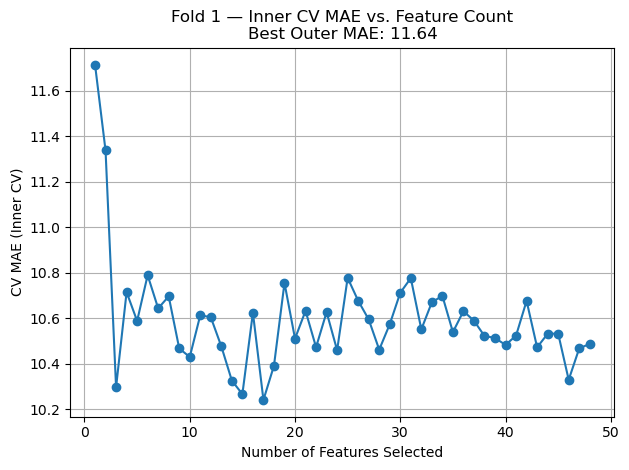

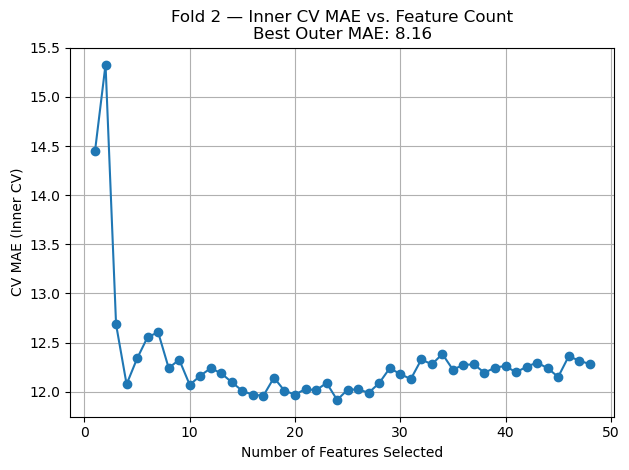

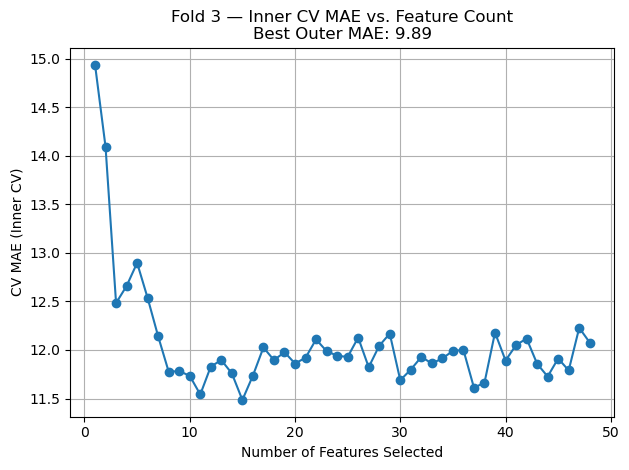


🏆 === BEST COMBINATION ACROSS ALL FOLDS ===
Best found in outer fold: 2
Lowest MAE: 8.16

🔧 Best Hyperparameter Configuration:
  colsample_bytree: 1.0
  learning_rate: 0.05
  max_depth: 5
  n_estimators: 100
  subsample: 0.8

📌 Features Selected (Total: 24):
  - risk_status_mom
  - mean_mvpa
  - mean_sedentary
  - percent_active_eating_slope
  - fswitch_nok_mean
  - ps_response_slope
  - pds_score
  - v1_eah_total_kcal
  - cebq_fr
  - cebq_eoe
  - cebq_eue
  - cebq_avoid
  - cfq_resp
  - cfq_pcw
  - cfq_ppw
  - cfq_cwc
  - cfq_rest
  - cfq_pressure
  - cfq_mon
  - pwlb_healthy
  - tfeq_cogcontrol
  - tfeq_disinhibition
  - bas_drive
  - brief2_gec_p


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# Load dataset
df = pd.read_csv("train_split_final.csv")

# Define features and target
feature_cols = [
    'risk_status_mom', 'age_yr', 'income', 'parent_ed', 'mean_mvpa', 'mean_sedentary',
    'percent_active_eating_slope', 'percent_active_eating_intercept',
    'bite_size_slope', 'bite_size_int', 'fswitch_nok_mean',
    'ps_response_slope', 'ps_response_int',
    'pds_score', 'v1_meal_total_kcal', 'v1_eah_total_kcal',
    'cebq_fr', 'cebq_eoe', 'cebq_ef', 'cebq_dd', 'cebq_sr', 'cebq_se',
    'cebq_eue', 'cebq_ff', 'cebq_approach', 'cebq_avoid', 'cfq_resp',
    'cfq_pcw', 'cfq_ppw', 'cfq_cwc', 'cfq_rest', 'cfq_pressure', 'cfq_mon',
    'ffbs_control', 'ffbs_presence', 'ffbs_ch_choice', 'ffbs_org',
    'pwlb_healthy', 'pwlb_unhealthy', 'tfeq_cogcontrol',
    'tfeq_disinhibition', 'tfeq_hunger', 'bis', 'bas_funseeking',
    'bas_drive', 'bas_rewardresp', 'brief2_gec_p', 'sex_1'
]
target = 'v7_bmi_percentile'
feature_names = np.array(feature_cols)

X = df[feature_cols].values
y = df[target].values

# 3-fold outer CV for honest model performance estimation
outer_cv = KFold(n_splits=3, shuffle=True, random_state=42)

# Hyperparameter grid for XGBoost
param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [50,100, 200],
    'subsample': [0.8],
    'colsample_bytree': [0.8, 1.0]
}

results_by_fold = []

# Outer loop
for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
    print(f"\n🔁 Outer Fold {fold}")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    fold_results = []

    # Grid search over hyperparameters
    for params in ParameterGrid(param_grid):
        model = XGBRegressor(objective='reg:squarederror', random_state=42, **params)

        # RFECV with 3-fold inner CV
        rfecv = RFECV(
            estimator=model,
            step=1,
            cv=3,
            scoring='neg_mean_absolute_error',
            n_jobs=-1
        )
        rfecv.fit(X_train, y_train)

        selected_mask = rfecv.support_
        selected_features = feature_names[selected_mask]

        # Re-train model on selected features
        model.fit(rfecv.transform(X_train), y_train)
        preds = model.predict(rfecv.transform(X_test))
        mae = mean_absolute_error(y_test, preds)

        fold_results.append({
            "params": params,
            "mae": mae,
            "n_features": selected_mask.sum(),
            "features": selected_features,
            "cv_mae_by_features": -rfecv.cv_results_['mean_test_score']
          # Flip to positive MAE
        })

    # Pick best inner model for this outer fold
    best = sorted(fold_results, key=lambda x: x['mae'])[0]
    results_by_fold.append(best)

    print(f"✅ Best MAE: {best['mae']:.2f}")
    print(f"📊 Best Hyperparams: {best['params']}")
    print(f"🔢 Features Selected ({best['n_features']}): {list(best['features'])}")

# Plot CV MAE vs. number of features
for i, res in enumerate(results_by_fold):
    plt.figure()
    plt.plot(range(1, len(res["cv_mae_by_features"]) + 1), res["cv_mae_by_features"], marker='o')
    plt.xlabel("Number of Features Selected")
    plt.ylabel("CV MAE (Inner CV)")
    plt.title(f"Fold {i+1} — Inner CV MAE vs. Feature Count\nBest Outer MAE: {res['mae']:.2f}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Best model across all folds
all_maes = [r['mae'] for r in results_by_fold]
best_fold_idx = int(np.argmin(all_maes))
best_overall = results_by_fold[best_fold_idx]

print("\n🏆 === BEST COMBINATION ACROSS ALL FOLDS ===")
print(f"Best found in outer fold: {best_fold_idx + 1}")
print(f"Lowest MAE: {best_overall['mae']:.2f}")

print("\n🔧 Best Hyperparameter Configuration:")
for key, val in best_overall['params'].items():
    print(f"  {key}: {val}")

print("\n📌 Features Selected (Total: {}):".format(best_overall['n_features']))
for feat in best_overall['features']:
    print(f"  - {feat}")

# Training Models

#### Model Training with BMI% and without BMI% - separately (based on above selected features)

In [36]:
import pandas as pd
from xgboost import XGBRegressor
import joblib

# --- Load data ---
df = pd.read_csv("train_split_stratified.csv")
target = 'v7_bmi_percentile'
y = df[target]

# ===============================
# ✅ Model 1: With Baseline BMI Percentile
# ===============================
features_with_bmi = ['bmi_percentile','mean_sedentary', 'mean_mvpa']  # Best model used only this feature
X_bmi = df[features_with_bmi]

model_bmi = XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=0.8,
    learning_rate=0.1,
    max_depth=3,
    n_estimators=50,
    subsample=0.8,
    random_state=42
)
model_bmi.fit(X_bmi, y)
print("✅ Trained model WITH baseline BMI percentile")

# Save model
joblib.dump(model_bmi, "xgb_model_with_bmi.pkl")
print("💾 Saved: xgb_model_with_bmi.pkl")


# ===============================
# ✅ Model 2: Without Baseline BMI Percentile
# ===============================
features_behavioral = [
    'risk_status_mom', 'mean_mvpa', 'mean_sedentary',
    'percent_active_eating_slope', 'fswitch_nok_mean', 'ps_response_slope',
    'pds_score', 'v1_eah_total_kcal', 'cebq_fr', 'cebq_eoe', 'cebq_eue',
    'cebq_avoid', 'cfq_resp', 'cfq_pcw', 'cfq_ppw', 'cfq_cwc', 'cfq_rest',
    'cfq_pressure', 'cfq_mon', 'pwlb_healthy', 'tfeq_cogcontrol',
    'tfeq_disinhibition', 'bas_drive', 'brief2_gec_p'
]  # 24 features from best-performing fold
X_behavior = df[features_behavioral]

model_behavior = XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=1.0,
    learning_rate=0.05,
    max_depth=5,
    n_estimators=100,
    subsample=0.8,
    random_state=42
)
model_behavior.fit(X_behavior, y)
print("✅ Trained model WITHOUT baseline BMI percentile")

# Save model
joblib.dump(model_behavior, "xgb_behavior_model_without_bmi.pkl")
print("💾 Saved: xgb_behavior_model_without_bmi.pkl")

✅ Trained model WITH baseline BMI percentile
💾 Saved: xgb_model_with_bmi.pkl
✅ Trained model WITHOUT baseline BMI percentile
💾 Saved: xgb_behavior_model_without_bmi.pkl


#### Model Evaluation of separate models: with BMI% and without BMI% - separately

In [41]:
import pandas as pd
import joblib
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Load test data ---
test_df = pd.read_csv("test_split_stratified.csv")

# --- One-hot encode 'sex' if applicable ---
if 'sex' in test_df.columns and 'sex_1' not in test_df.columns:
    test_df['sex_1'] = test_df['sex'].map({'Male': 0, 'Female': 1})  # Adjust if needed

# --- Define target and features ---
target = 'v7_bmi_percentile'
y_test = test_df[target]

# === Model 1: WITH Baseline BMI Percentile ===
features_with_bmi = ['bmi_percentile', 'mean_sedentary', 'mean_mvpa'] # Based on best fold result

# === Model 2: WITHOUT Baseline BMI Percentile ===
features_behavioral = [
    'risk_status_mom', 'mean_mvpa', 'mean_sedentary',
    'percent_active_eating_slope', 'fswitch_nok_mean', 'ps_response_slope',
    'pds_score', 'v1_eah_total_kcal', 'cebq_fr', 'cebq_eoe', 'cebq_eue',
    'cebq_avoid', 'cfq_resp', 'cfq_pcw', 'cfq_ppw', 'cfq_cwc', 'cfq_rest',
    'cfq_pressure', 'cfq_mon', 'pwlb_healthy', 'tfeq_cogcontrol',
    'tfeq_disinhibition', 'bas_drive', 'brief2_gec_p'
]

# --- Load models ---
model_bmi = joblib.load("xgb_model_with_bmi.pkl")
model_behavior = joblib.load("xgb_behavior_model_without_bmi.pkl")

# --- Prepare inputs ---
X_test_bmi = test_df[features_with_bmi]
X_test_behavior = test_df[features_behavioral]

# --- Evaluation function ---
def evaluate_model(y_true, y_pred, label):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n📊 Evaluation: {label}")
    print(f"  MAE : {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²  : {r2:.2f}")
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

# --- Run evaluations ---
y_pred_bmi = model_bmi.predict(X_test_bmi)
metrics_bmi = evaluate_model(y_test, y_pred_bmi, "BMI-Based Model")

y_pred_behavior = model_behavior.predict(X_test_behavior)
metrics_behavior = evaluate_model(y_test, y_pred_behavior, "Behavioral Model (No BMI%)")

# --- Summary ---
print("\n✅ Summary:")
print("BMI-Based Model Metrics:", metrics_bmi)
print("Behavioral Model Metrics:", metrics_behavior)


📊 Evaluation: BMI-Based Model
  MAE : 3.01
  RMSE: 4.37
  R²  : 0.91

📊 Evaluation: Behavioral Model (No BMI%)
  MAE : 6.82
  RMSE: 10.40
  R²  : 0.48

✅ Summary:
BMI-Based Model Metrics: {'MAE': 3.008556574945865, 'RMSE': 4.36750497243158, 'R2': 0.9083791780171705}
Behavioral Model Metrics: {'MAE': 6.821272561999336, 'RMSE': 10.395473087377095, 'R2': 0.48094200552143607}


#### SHAP for the models : with BMI and without BMI%

📊 SHAP Summary Plot: Behavioral Model (No BMI%)


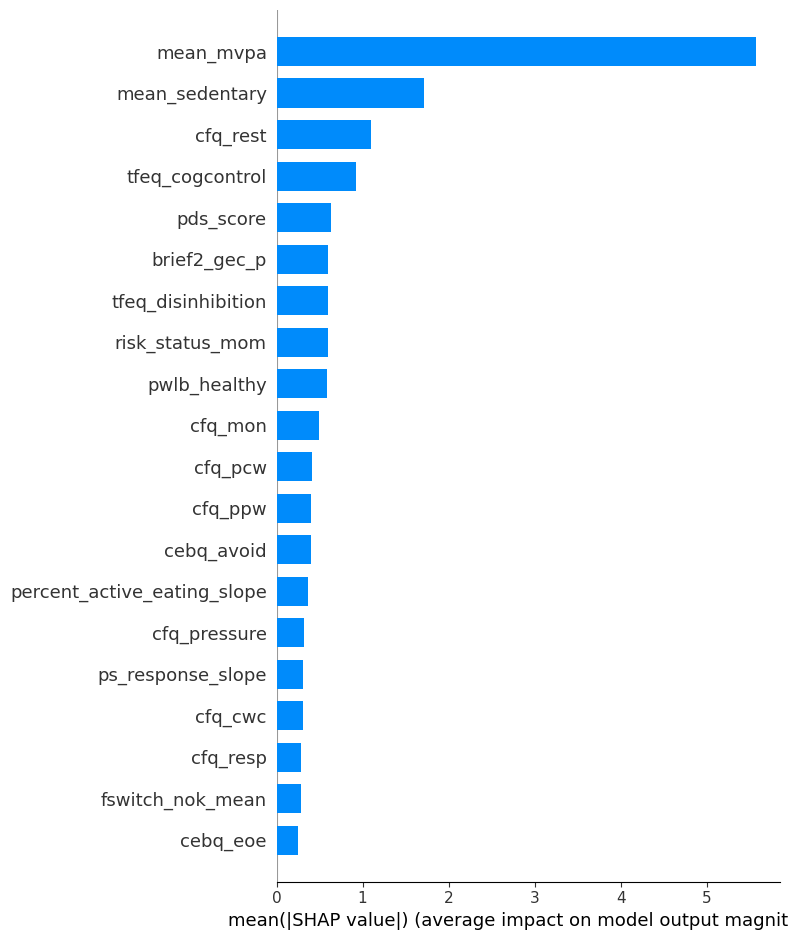

📊 SHAP Summary Plot: BMI-Based Model


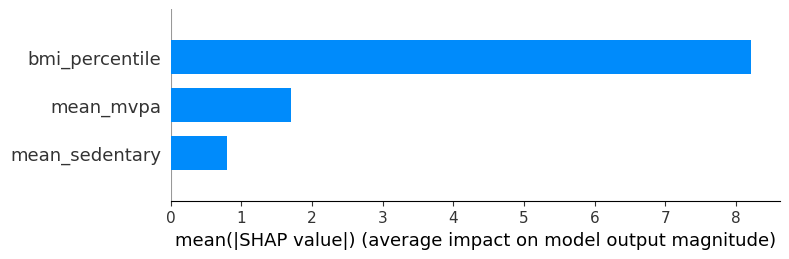

📊 SHAP Beeswarm Plot: Behavioral Model (No BMI%)


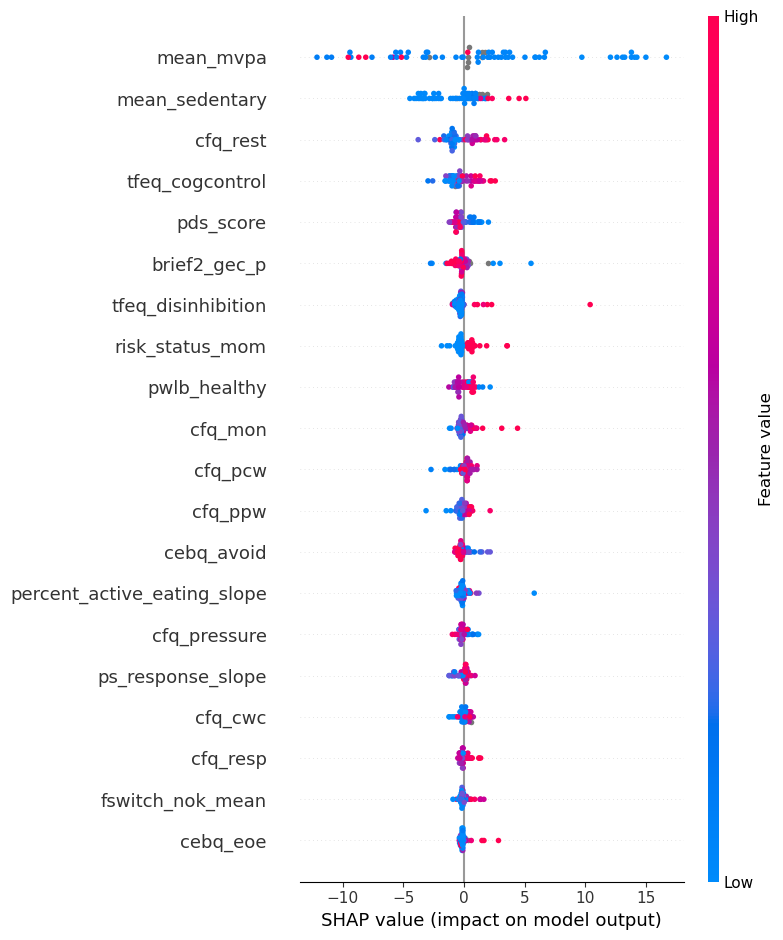

📊 SHAP Beeswarm Plot: BMI-Based Model


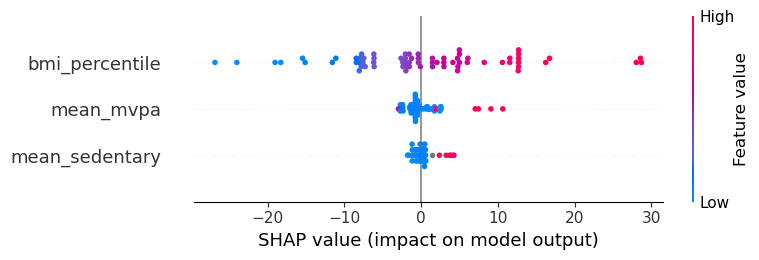

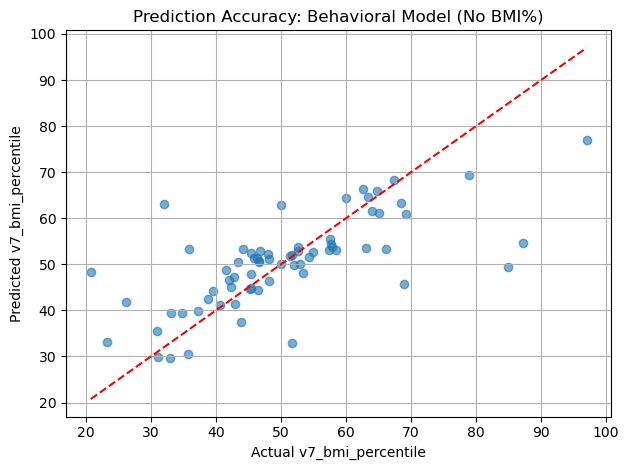

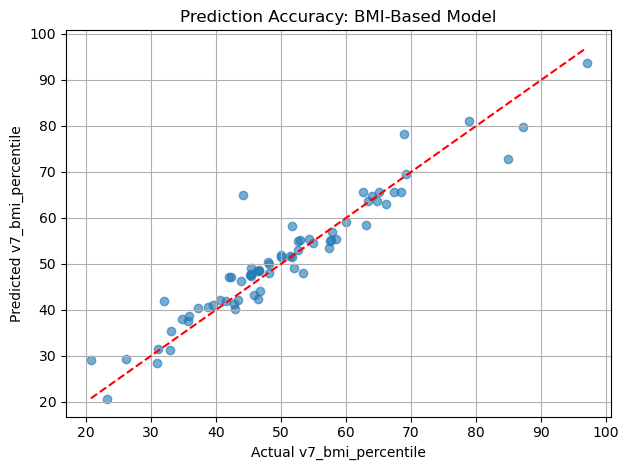

In [42]:
import shap
import matplotlib.pyplot as plt

# --- TreeExplainer avoids torch dependencies ---
explainer_behavior = shap.TreeExplainer(model_behavior)
shap_values_behavior = explainer_behavior.shap_values(X_test_behavior)

explainer_bmi = shap.TreeExplainer(model_bmi)
shap_values_bmi = explainer_bmi.shap_values(X_test_bmi)

# --- SHAP summary bar plots ---
print("📊 SHAP Summary Plot: Behavioral Model (No BMI%)")
shap.summary_plot(shap_values_behavior, X_test_behavior, plot_type="bar", show=False)
plt.tight_layout()
plt.show()

print("📊 SHAP Summary Plot: BMI-Based Model")
shap.summary_plot(shap_values_bmi, X_test_bmi, plot_type="bar", show=False)
plt.tight_layout()
plt.show()

# --- SHAP beeswarm plots ---
print("📊 SHAP Beeswarm Plot: Behavioral Model (No BMI%)")
shap.summary_plot(shap_values_behavior, X_test_behavior, show=False)
plt.tight_layout()
plt.show()

print("📊 SHAP Beeswarm Plot: BMI-Based Model")
shap.summary_plot(shap_values_bmi, X_test_bmi, show=False)
plt.tight_layout()
plt.show()

# --- Scatter plot: Prediction Accuracy (Actual vs Predicted) ---
plt.figure()
plt.scatter(y_test, y_pred_behavior, alpha=0.6)
plt.xlabel("Actual v7_bmi_percentile")
plt.ylabel("Predicted v7_bmi_percentile")
plt.title("Prediction Accuracy: Behavioral Model (No BMI%)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.scatter(y_test, y_pred_bmi, alpha=0.6)
plt.xlabel("Actual v7_bmi_percentile")
plt.ylabel("Predicted v7_bmi_percentile")
plt.title("Prediction Accuracy: BMI-Based Model")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.grid(True)
plt.tight_layout()
plt.show()